In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn
import numpy as np
import sys
import matplotlib.pyplot as plt
import math
import random
import sklearn.metrics as perf
import os
import cv2

from models.models import MTLClassifier, AgeRegressor, GenderClassifier, EthnicityClassifier
from utils.data import FacesDataset, data_transform
from utils.training import train_mtl_model, train_age_model, train_gender_model, train_ethnicity_model
from utils.evaluation import run_evaluation, show_example_predictions

# Link to dataset: https://susanqq.github.io/UTKFace/
# Relevant paper: Multi-task learning using uncertainty to weigh losses: https://arxiv.org/abs/1705.07115

In [2]:
### Load in the data
folder = 'UTKFace'
transform = data_transform()
dataset = FacesDataset(folder=folder, transform=transform)

In [3]:
### Set up train and val datasets and loaders
train_len = int(len(dataset)*0.8)
val_len = len(dataset) - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len], torch.Generator().manual_seed(8))

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)

In [4]:
### Set up model, loss, and optimizer
model = MTLClassifier()
model = model.cuda()

age_criterion = nn.MSELoss()
gender_criterion = nn.CrossEntropyLoss()
ethni_criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())

### Fine-tune this model

In [15]:
# Set up and run model training
num_epochs = 10
age_coeff = 0.004
gender_coeff = 2
ethni_coeff = 1

train_mtl_model(num_epochs=num_epochs, model=model, optimizer=optimizer,
                train_loader=train_loader, val_loader=val_loader,
                age_criterion=age_criterion, gender_criterion=gender_criterion, ethni_criterion=ethni_criterion,
                age_coeff=age_coeff, gender_coeff=gender_coeff, ethni_coeff=ethni_coeff)

Epoch 0, val loss: inf -> 0.13378, train loss: 0.15788
Epoch 0, age val loss: 0.04655, gender val loss: 0.03602, ethnicity val loss: 0.05122

Epoch 1, val loss: 0.13378 -> 0.09537, train loss: 0.11133
Epoch 1, age val loss: 0.02700, gender val loss: 0.02819, ethnicity val loss: 0.04018

Epoch 2, val loss: 0.09537 -> 0.09439, train loss: 0.09569
Epoch 2, age val loss: 0.02068, gender val loss: 0.02918, ethnicity val loss: 0.04453

Epoch 3, val loss: 0.09569, train loss: 0.08595
Epoch 3, age val loss: 0.02598, gender val loss: 0.03151, ethnicity val loss: 0.03820

Epoch 4, val loss: 0.09439 -> 0.08297, train loss: 0.07619
Epoch 4, age val loss: 0.01773, gender val loss: 0.02624, ethnicity val loss: 0.03900

Epoch 5, val loss: 0.08297 -> 0.08223, train loss: 0.06731
Epoch 5, age val loss: 0.01762, gender val loss: 0.02752, ethnicity val loss: 0.03709

Epoch 6, val loss: 0.08223 -> 0.07446, train loss: 0.06136
Epoch 6, age val loss: 0.01662, gender val loss: 0.02431, ethnicity val loss: 0.

### Test predictions

In [5]:
tasks = ['age', 'gender', 'ethnicity']
mtl_model = True
model = MTLClassifier()
model.load_state_dict(torch.load('models/mtl_face_model_v1.pt'))

score_dict = run_evaluation(model, val_loader, tasks, mtl_model)
print(score_dict)

{'age': (8.143952, 0.8319978705707992), 'gender': (0.9203694240624956, 0.9209027631301413), 'ethnicity': (0.6931498642254639, 0.8211347816916262)}


### Show example predictions

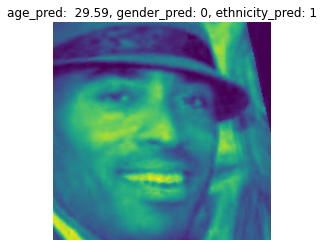

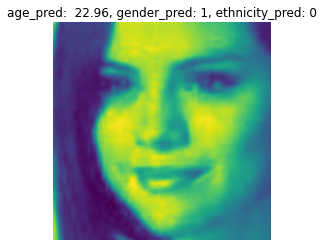

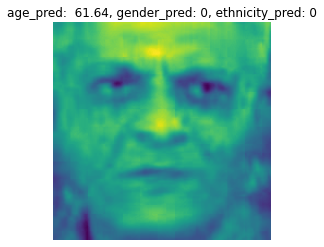

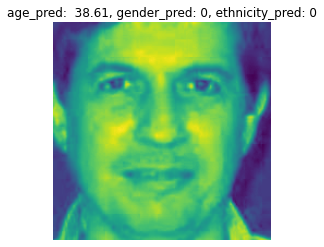

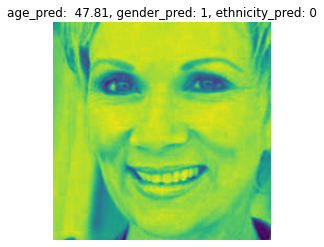

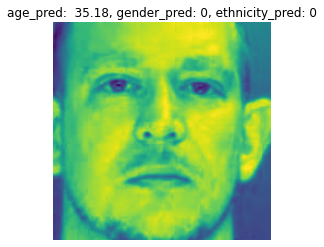

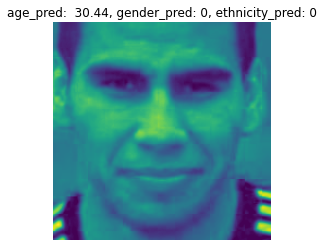

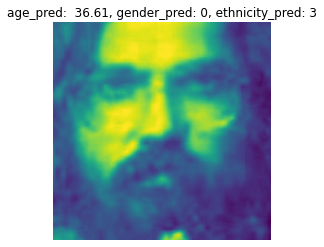

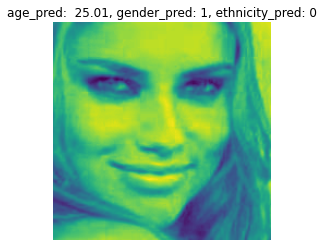

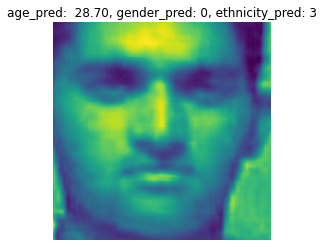

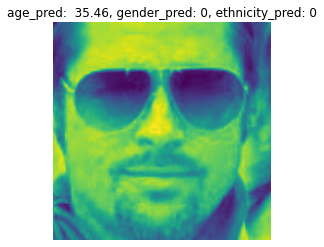

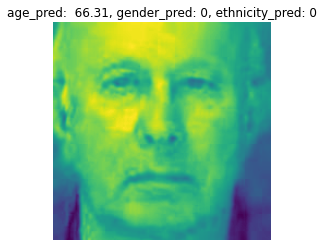

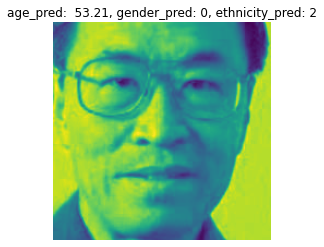

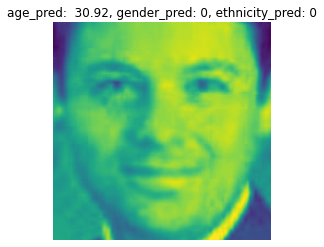

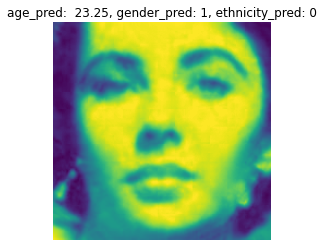

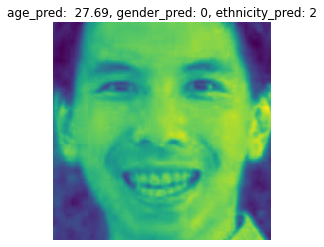

In [6]:
show_example_predictions(model, val_loader)

In [7]:
### Try vgg face as the encoder: https://github.com/chi0tzp/PyVGGFace
### https://www.kaggle.com/shubhendumishra/recognizing-faces-in-the-wild-vggface-pytorch

### Single task model training

#### Age

In [19]:
### Set up model, loss, and optimizer
model = AgeRegressor()
model = model.cuda()

age_criterion = nn.MSELoss()
age_coeff = 0.004
optimizer = torch.optim.Adam(model.parameters())


# Set up and run model training
num_epochs = 10

train_age_model(num_epochs=num_epochs, model=model, optimizer=optimizer,
                train_loader=train_loader, val_loader=val_loader, age_criterion=age_criterion,
                age_coeff=age_coeff)

Epoch 0, val loss: inf -> 0.02241, train loss: 0.04218
Epoch 1, val loss: 0.03104, train loss: 0.02665
Epoch 2, val loss: 0.02241 -> 0.01973, train loss: 0.02204
Epoch 3, val loss: 0.01973 -> 0.01636, train loss: 0.01842
Epoch 4, val loss: 0.02306, train loss: 0.01666
Epoch 5, val loss: 0.01636 -> 0.01622, train loss: 0.01512
Epoch 6, val loss: 0.01622 -> 0.01544, train loss: 0.01297
Epoch 7, val loss: 0.02080, train loss: 0.01145
Epoch 8, val loss: 0.02247, train loss: 0.01031
Epoch 9, val loss: 0.01544 -> 0.01522, train loss: 0.00902


In [8]:
### Eval
tasks = ['age']
mtl_model = False
model = AgeRegressor()
model.load_state_dict(torch.load('models/age_face_model_v1.pt'))

score_dict = run_evaluation(model, val_loader, tasks, mtl_model)
print(score_dict)

{'age': (7.7906766, 0.8462572377278591)}


#### Gender

In [20]:
### Set up model, loss, and optimizer
model = GenderClassifier()
model = model.cuda()

gender_criterion = nn.CrossEntropyLoss()
gender_coeff = 2
optimizer = torch.optim.Adam(model.parameters())


# Set up and run model training
num_epochs = 10

train_gender_model(num_epochs=num_epochs, model=model, optimizer=optimizer,
                   train_loader=train_loader, val_loader=val_loader, gender_criterion=gender_criterion,
                   gender_coeff=gender_coeff)

Epoch 0, val loss: inf -> 0.03726, train loss: 0.04645
Epoch 1, val loss: 0.03726 -> 0.03027, train loss: 0.03539
Epoch 2, val loss: 0.03324, train loss: 0.03158
Epoch 3, val loss: 0.03127, train loss: 0.02826
Epoch 4, val loss: 0.03027 -> 0.02760, train loss: 0.02518
Epoch 5, val loss: 0.02970, train loss: 0.02251
Epoch 6, val loss: 0.02783, train loss: 0.02097
Epoch 7, val loss: 0.03172, train loss: 0.02141
Epoch 8, val loss: 0.02834, train loss: 0.01622
Epoch 9, val loss: 0.03366, train loss: 0.01458


In [9]:
### Eval
tasks = ['gender']
mtl_model = False
model = GenderClassifier()
model.load_state_dict(torch.load('models/gender_face_model_v1.pt'))

score_dict = run_evaluation(model, val_loader, tasks, mtl_model)
print(score_dict)

{'gender': (0.9172635689918666, 0.9175279476903607)}


#### Ethnicity

In [21]:
### Set up model, loss, and optimizer
model = EthnicityClassifier()
model = model.cuda()

ethni_criterion = nn.CrossEntropyLoss()
ethni_coeff = 1
optimizer = torch.optim.Adam(model.parameters())


# Set up and run model training
num_epochs = 10

train_ethnicity_model(num_epochs=num_epochs, model=model, optimizer=optimizer,
                   train_loader=train_loader, val_loader=val_loader, ethni_criterion=ethni_criterion,
                   ethni_coeff=ethni_coeff)

Epoch 0, val loss: inf -> 0.05319, train loss: 0.06255
Epoch 1, val loss: 0.05319 -> 0.04166, train loss: 0.04695
Epoch 2, val loss: 0.04166 -> 0.03824, train loss: 0.04115
Epoch 3, val loss: 0.04057, train loss: 0.03745
Epoch 4, val loss: 0.03824 -> 0.03813, train loss: 0.03373
Epoch 5, val loss: 0.03902, train loss: 0.03043
Epoch 6, val loss: 0.03813 -> 0.03745, train loss: 0.02695
Epoch 7, val loss: 0.03883, train loss: 0.02342
Epoch 8, val loss: 0.03745 -> 0.03421, train loss: 0.02094
Epoch 9, val loss: 0.04759, train loss: 0.01737


In [10]:
### Eval
tasks = ['ethnicity']
mtl_model = False
model = EthnicityClassifier()
model.load_state_dict(torch.load('models/ethnicity_face_model_v1.pt'))

score_dict = run_evaluation(model, val_loader, tasks, mtl_model)
print(score_dict)

{'ethnicity': (0.7399093747093902, 0.8164944104619278)}
